In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax.scipy.linalg import cholesky, cho_factor, cho_solve
from jax.scipy.optimize import minimize
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_box

import pandas as pd

In [2]:
#https://www.textfixer.com/tools/remove-line-breaks.php

In [3]:
PCANet = pd.read_csv("data/PCA_Helmhotz.csv", header = None).to_numpy()
DeepONet = pd.read_csv("data/DeepONet_Helmhotz.csv", header = None).to_numpy()
Para = pd.read_csv("data/PARA_Helmhotz.csv", header = None).to_numpy()
FNO = pd.read_csv("data/FNO_Helmhotz.csv", header = None).to_numpy()

In [4]:
np.min(PCANet[:,4]), np.min(FNO[:,4]), np.min(DeepONet[:, 4]), np.min(Para[:, 4])

(DeviceArray(0.02128051, dtype=float64),
 DeviceArray(0.01864324, dtype=float64),
 DeviceArray(0.05882819, dtype=float64),
 DeviceArray(0.12542812, dtype=float64))

In [5]:
#The columns = [Nexamples, network width, Train, Test]

Text(0, 0.5, 'Test accuracy')

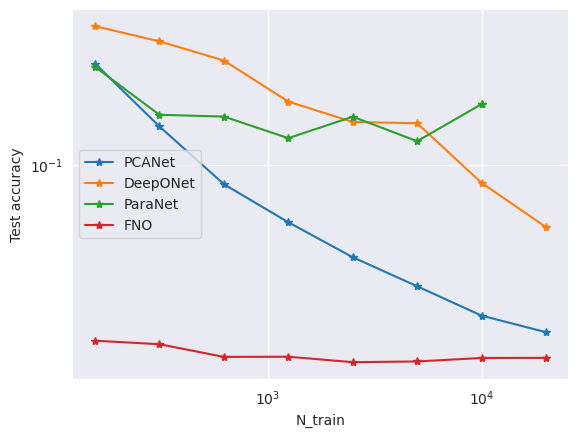

In [5]:
import seaborn as sns
sns.set_style('darkgrid')

#plt.plot(PCA[PCA[:,1] == 512][:,0], PCA[PCA[:,1] == 512][:, 3])
plt.plot(PCANet[PCANet[:,1] == 512][:,0], PCANet[PCANet[:,1] == 512][:, 4],'-*', label = 'PCANet')
plt.plot(DeepONet[DeepONet[:,1] == 512][:,0], DeepONet[DeepONet[:,1] == 512][:, 3],'-*', label = 'DeepONet')
plt.plot(Para[Para[:,1] == 512][:,0], Para[Para[:,1] == 512][:, 3],'-*', label = 'ParaNet')
plt.plot(FNO[FNO[:,1] == 32][:,0], FNO[FNO[:,1] == 32][:, 3],'-*', label = 'FNO')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N_train')
plt.ylabel('Test accuracy')

In [6]:
Inputs = onp.load('data/Helmholtz_inputs.npy')
Outputs = onp.load('data/Helmholtz_outputs.npy')

In [7]:
Inputs = Inputs.transpose((2,1,0))
Outputs = Outputs.transpose((2,1,0))

Inputs_fl = Inputs.reshape(len(Inputs), 101*101)
Outputs_fl = Outputs.reshape(len(Outputs), 101*101)

In [9]:
Ntrain = 20000

In [10]:
Xtr = Inputs_fl[:Ntrain]


In [11]:
%%time
pca = PCA(n_components=200)
Xtr = pca.fit_transform(Xtr)

CPU times: user 1min 26s, sys: 2.83 s, total: 1min 29s
Wall time: 5.62 s


In [12]:
Xtest = pca.transform(Inputs_fl[20000:])
Ytr = Outputs_fl[:Ntrain]
Ytest = Outputs_fl[20000:]


In [13]:
def sqeuclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum( (x - y) ** 2)
dists = jit(vmap(vmap(sqeuclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))

def euclidean_distances(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum( (x - y) ** 2))
sqdists = jit(vmap(vmap(euclidean_distances, in_axes=(None, 0)), in_axes=(0, None)))


@jit
def matern(v1, v2, sigma = 50):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = sqdists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def exp(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    return np.exp(-d/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)

@jit
def iq(v1, v2, sigma):
    #V1 is a [k1] vector
    #V2 is a [k2] vector
    #returns a k1xk2 matrix
    d = dists(v1, v2)
    #return a*np.exp(-d**2/sigma)
    #return (1+np.sqrt(5)*d/sigma +5*d**2/(3*sigma**2))*np.exp(-np.sqrt(5)*d/sigma)
    return 1/np.sqrt(d+sigma)

In [14]:
nugget = 1e-8

In [15]:
def aux(kernel, s, nugget):
    k = kernel
    Kxx = k(Xtr, Xtr, s)
    nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
    L = cho_factor(nuggeted_matrix)
    result = cho_solve(L, Ytr)
    Train_pred = Kxx@result #train predictions
    K_te_tr = k(Xtest, Xtr,s)
    Test_pred = K_te_tr@result #test predictions

    np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))

    aux1 = np.mean(np.linalg.norm(Ytr-Train_pred, axis = 1))
    aux2 = np.mean(np.linalg.norm(Train_pred-Ytr, axis = 1)/np.linalg.norm(Ytr, axis = 1))
    aux3 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1))
    aux4 = np.mean(np.linalg.norm(Ytest-Test_pred, axis = 1)/np.linalg.norm(Ytest, axis = 1))
    print(s, nugget)
    print("\n Train error (abs): {0} \n Train error (rel): {1} \n Test error (abs): {2} \n Test error (rel): {3}".format(aux1, aux2, aux3, aux4))
    print('---')

In [20]:
for kernel in [iq]:
    for s in [600, 700, 800, 900, 1000]:
        for nugget in [1e-8]:
            aux(kernel, s, nugget)

600 1e-08

 Train error (abs): 1.7255591467469704e-05 
 Train error (rel): 1.5014840591098168e-05 
 Test error (abs): 0.013036223384733649 
 Test error (rel): 0.010565668447116289
---
700 1e-08

 Train error (abs): 2.9186157157352634e-05 
 Train error (rel): 2.542112346729629e-05 
 Test error (abs): 0.01274482017512062 
 Test error (rel): 0.010345291348567398
---
800 1e-08

 Train error (abs): 4.62941970590327e-05 
 Train error (rel): 4.0349901767499644e-05 
 Test error (abs): 0.012539715604524708 
 Test error (rel): 0.010192235307140567
---
900 1e-08

 Train error (abs): 6.977206736901927e-05 
 Train error (rel): 6.084100611688155e-05 
 Test error (abs): 0.012394088469080222 
 Test error (rel): 0.010085382945958699
---
1000 1e-08

 Train error (abs): 0.00010083169805866168 
 Train error (rel): 8.794847109599656e-05 
 Test error (abs): 0.01229049839704777 
 Test error (rel): 0.010010998986511345
---


In [21]:
%%time
Kxx = iq(Xtr, Xtr, 1000)
nuggeted_matrix = Kxx.at[np.diag_indices_from(Kxx)].add(nugget)
L = cho_factor(nuggeted_matrix)
result = cho_solve(L, Ytr)
Train_pred = Kxx@result #train predictions
K_te_tr = iq(Xtest, Xtr,1000)
Test_pred = K_te_tr@result #test predictions


CPU times: user 1.05 s, sys: 396 ms, total: 1.44 s
Wall time: 1.43 s


In [27]:
np.linalg.norm(Test_pred[41]-Ytest[41])/np.linalg.norm(Ytest[41])

DeviceArray(0.00560926, dtype=float64)

In [30]:
import pickle
pickle.dump(obj=[Ytest[41], Test_pred[41]], file = open('PredictedHH.pkl', 'wb'))

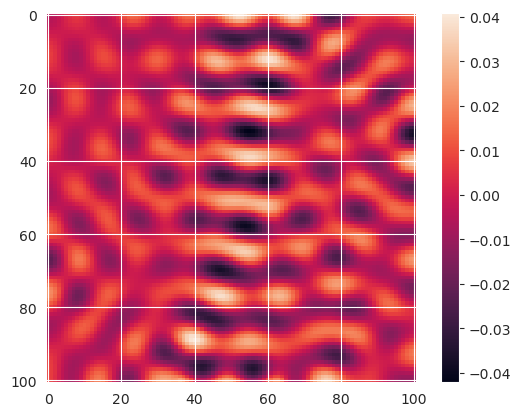

In [29]:
plt.imshow(Test_pred[41].reshape(101,101))
plt.colorbar()

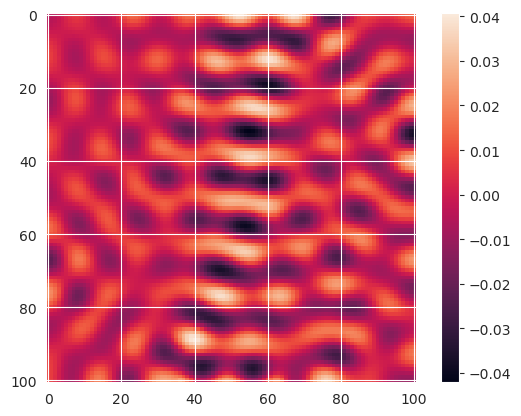

In [25]:
plt.imshow(Ytest[41].reshape(101,101))
plt.colorbar()

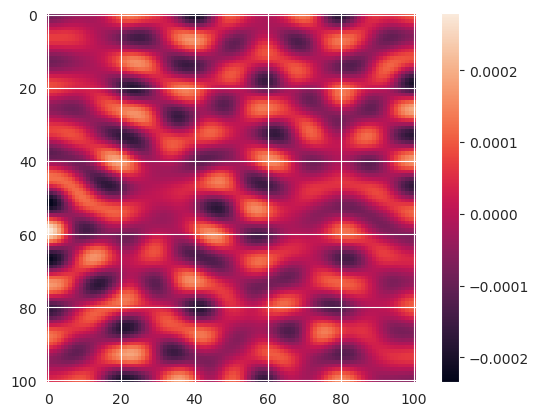

In [22]:
plt.imshow(Test_pred[41].reshape(101,101)-Ytest[41].reshape(101,101))
plt.colorbar()